## Filtering an ARMA process

In [1]:
cd ./03-kalman-filter/

/Users/gerardoduran/Documents/repos/filtering-notes/03-kalman-filter


In [2]:
import jax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
sns.set_palette("colorblind")

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import ssm

## Defining the ARMA process

In [36]:
key = jax.random.PRNGKey(314)

In [210]:
ma_n = 10
H_ma = jnp.ones(ma_n) * 1.0
H_ar = jnp.ones(3) * 0.35
H, F, T = ssm.init_arma_components(H_ma=H_ma)
dim_state = len(H)
R = jnp.eye(1) * 2.0 ** 2

In [211]:
n_steps = 100
sample = ssm.sample_ssm(key, F, H, T, R, n_steps)

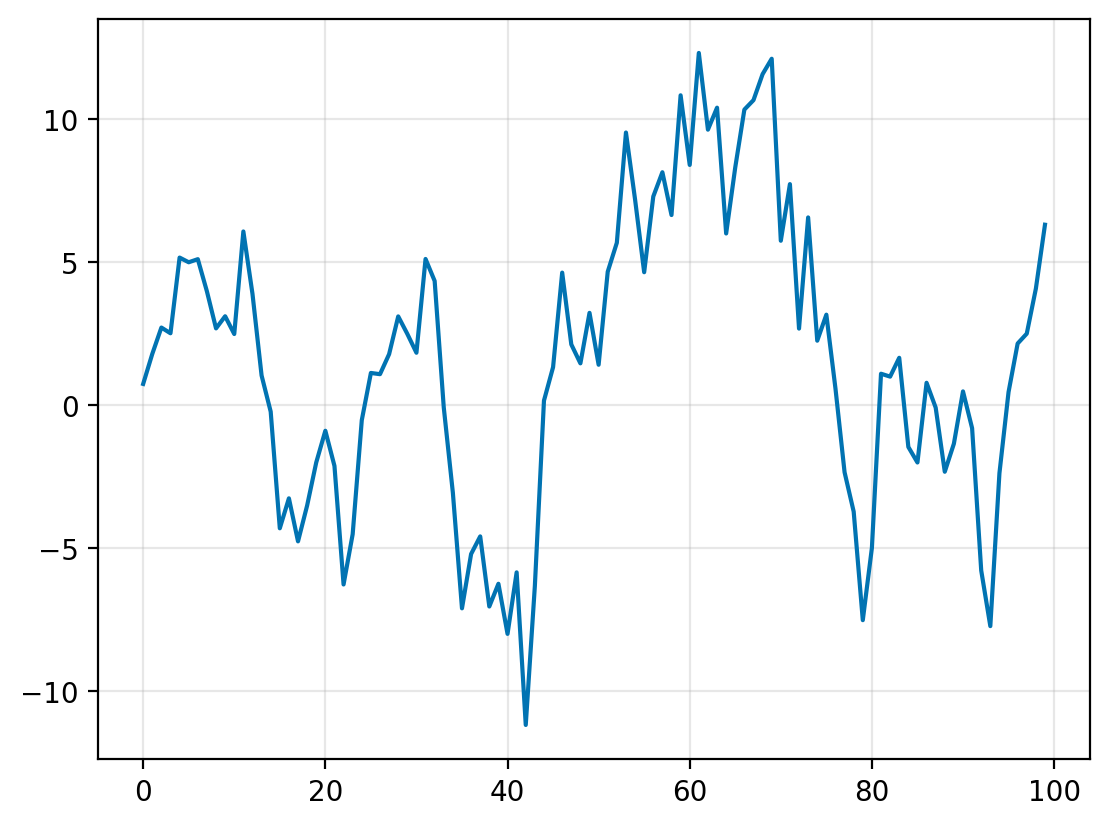

In [212]:
plt.plot(sample["y"])
plt.grid(alpha=0.3)

## The Kalman filter (with constant dynamics)

In [213]:
def kf_step(bel, y, H, F, R, Q):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu = mu_pred + K @ err
    Sigma = Sigma_pred - K @ S @ K.T
    bel_next = (mu, Sigma)

    out = {
        "mu": mu,
        "err": err,
        "yhat": H @ mu_pred
    }

    return bel_next, out

In [214]:
Q = T @ R @ T.T
_step = partial(kf_step, H=H[None, :], F=F, R=R, Q=Q)
y = sample["y"]

mu_init = jnp.zeros(dim_state)
Sigma_init = jnp.eye(dim_state)
bel_init = (mu_init, Sigma_init)

bel, hist = jax.lax.scan(_step, bel_init, y[:, None])

In [215]:
filter_hist = jnp.einsum("i,ti->t", H, hist["mu"])

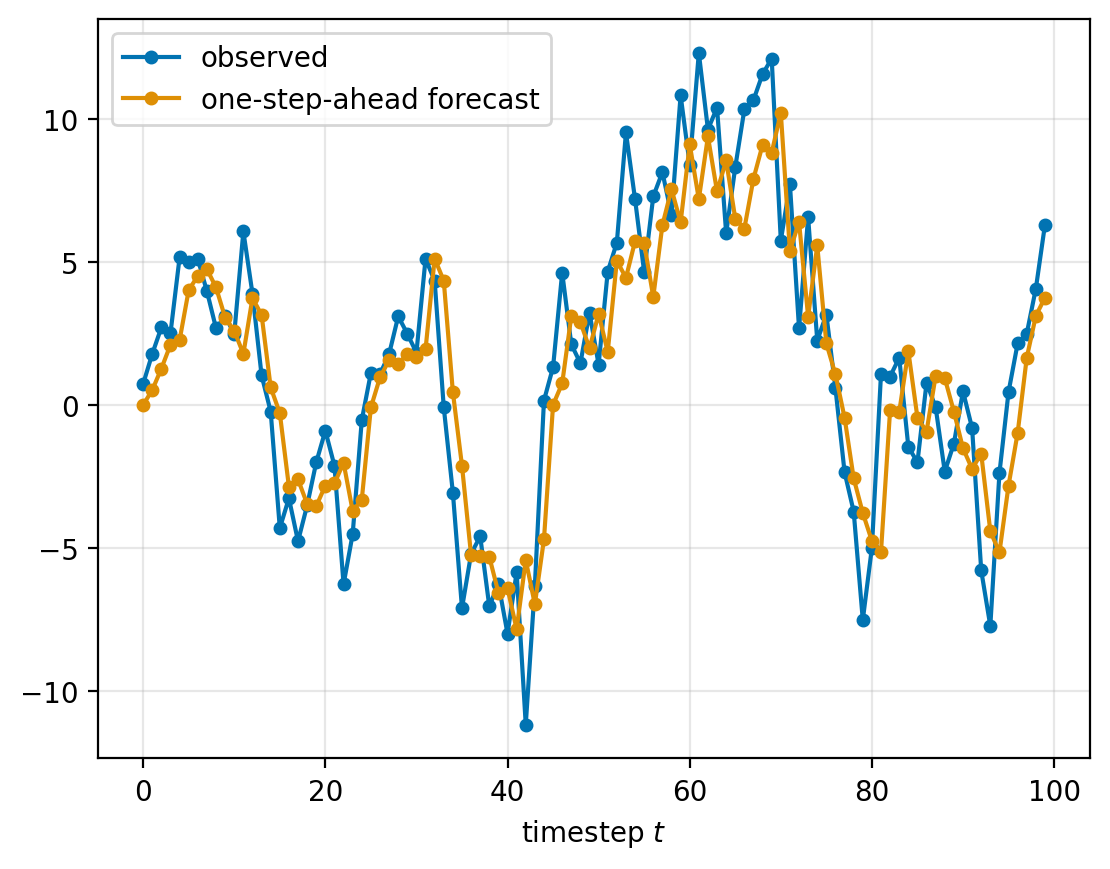

In [216]:
plt.plot(sample["y"], marker="o", markersize=4, label="observed")
plt.plot(hist["yhat"], marker="o", markersize=4, label="one-step-ahead forecast")
plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

In [218]:
def forecast_mean(F, mu, k):
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, mu_next
    steps = jnp.arange(k)
    _, mu_pred = jax.lax.scan(_step, mu, steps)
    return mu_pred

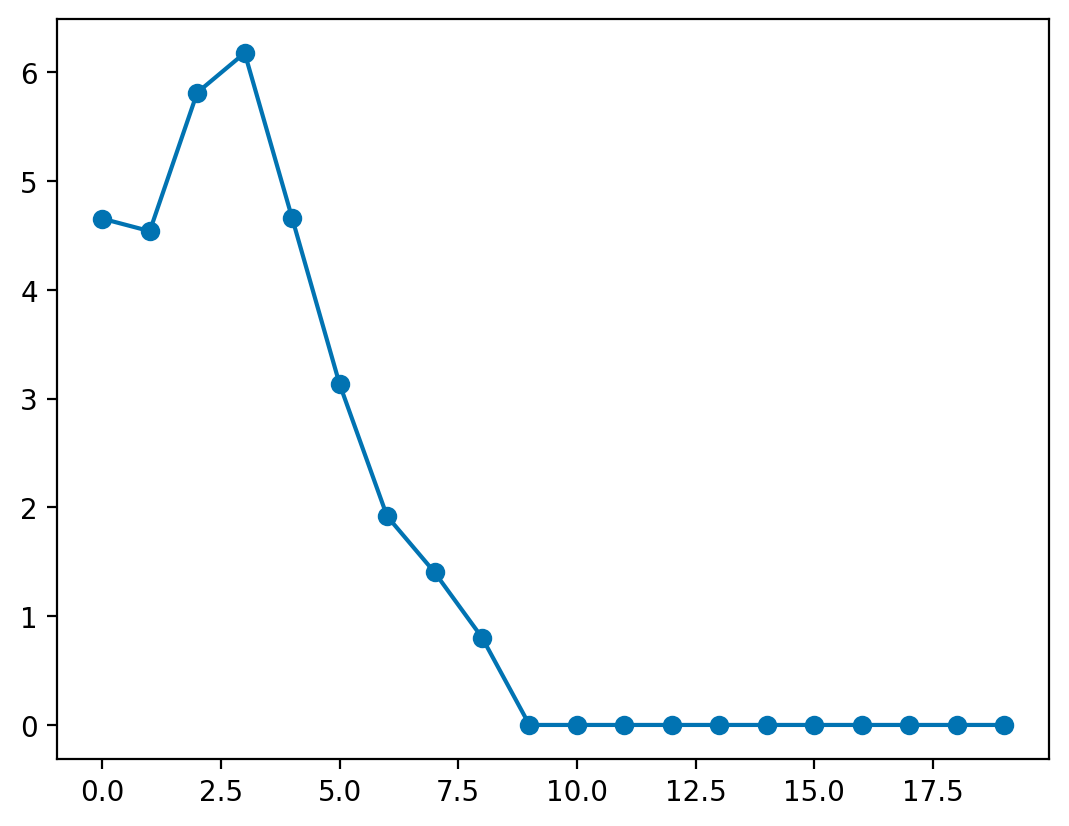

In [219]:
mu_pred = forecast_mean(F, bel[0], 20)
y_pred = jnp.einsum("d,td->t", H, mu_pred)
plt.plot(y_pred, marker="o")

### What went wrong?

$$
\begin{aligned}
    {\rm cov}(U_s, Y_{1:t})
    &= {\rm cov}({\cal T}E_{s}, Y_{1:t})\\
    &= {\cal T}\,
    \begin{bmatrix}
    {\rm cov}(E_{s}, Y_{1}) & \ldots & {\rm cov}(E_{s}, Y_{t})
    \end{bmatrix}\\
    &= {\cal T}\begin{bmatrix}
    {\rm cov}(E_{s}, F_1 + E_1) & \ldots & {\rm cov}(E_{s}, F_t + E_t)
    \end{bmatrix}
\end{aligned}
$$